In [5]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='127.0.0.1',
    user='root',
    password='12345',
    database='data_analysis'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Admin/Downloads/archive (7)'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64



KeyboardInterrupt: 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(
    host='127.0.0.1',
    user='root',
    password='12345',
    database='data_analysis'
)

cur = db.cursor()

### 1. List all unique cities where customers are located.

In [4]:
# Safely discard unread results from any previous query
while cur.nextset():
    pass

# Now run your actual query
query = """ SELECT DISTINCT(customer_city) FROM customers """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["City"])
df

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


### 2. Count the number of orders placed in 2017.

In [40]:
# Safely discard unread results from any previous query
while cur.nextset():
    pass

# Now run your actual query
query = """ SELECT COUNT(order_id) FROM orders 
            WHERE year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
data[0][0]


45101

### 3. Find the total sales per category.

In [21]:
# Safely discard unread results from any previous query
while cur.nextset():
    pass

# Now run your actual query
query = """ SELECT UPPER(products.product_category) category, ROUND(SUM(payments.payment_value),2) sales FROM products 
            JOIN order_items
            ON products.product_id = order_items.product_id
            JOIN payments
            ON order_items.order_id = payments.order_id 
            GROUP BY category """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["category", "sales"])
df

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


### 4. Calculate the percentage of orders that were paid in installments.

In [10]:
# Safely discard unread results from any previous query
while cur.nextset():
    pass

# Now run your actual query
query = """ SELECT (SUM(CASE WHEN payment_installments > 0 THEN 1 ELSE 0 END))/COUNT(*)*100 FROM payments """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['percentage'])
df

,percentage
0,99.9981


### 5. Count the number of customers from each state. 

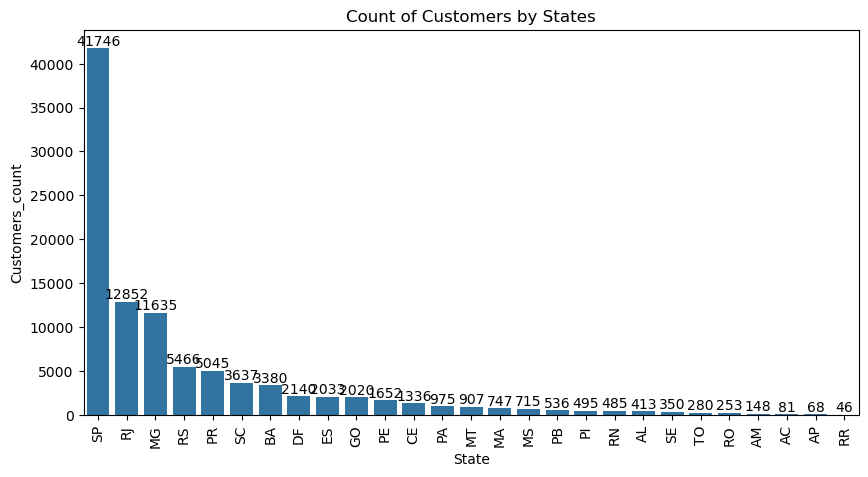

In [59]:
# Safely discard unread results from any previous query
while cur.nextset():
    pass

# Now run your actual query
query = """ SELECT customer_state, COUNT(customer_unique_id) FROM customers
GROUP BY customer_state; """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['State','Customers_count'])
df = df.sort_values(by = 'Customers_count', ascending = False)

plt.figure(figsize=(10,5))
ax = sns.barplot(x = df['State'],y = df['Customers_count'])
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.title('Count of Customers by States')
plt.show()

#### INTERMEDIATE
### 1. Calculate the number of orders per month in 2018.

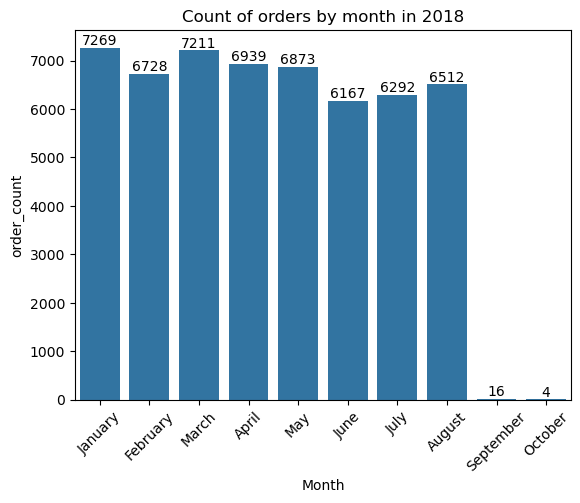

In [68]:
# Safely discard unread results from any previous query
while cur.nextset():
    pass

# Now run your actual query
query = """ SELECT  MONTHNAME(order_purchase_timestamp) AS Month,COUNT(order_id) FROM orders
WHERE YEAR(order_purchase_timestamp) = '2018'
GROUP BY MONTHNAME(order_purchase_timestamp); 
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Month','order_count'])
o = ['January','February','March','April','May','June','July','August','September','October']

ax = sns.barplot(x = df['Month'], y = df['order_count'],data = df, order = o)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title('Count of orders by month in 2018')
plt.show()

### 2. Find the average number of products per order, grouped by customer city.

In [75]:
# Safely discard unread results from any previous query
while cur.nextset():
    pass

# Now run your actual query
query = """ WITH count_per_order AS
(SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc FROM orders
JOIN order_items
ON orders.order_id = order_items.order_id
GROUP BY orders.order_id, orders.customer_id)

SELECT customers.customer_city, ROUND(AVG(count_per_order.oc),2) AS Average_orders FROM count_per_order
JOIN customers
ON count_per_order.customer_id = customers.customer_id
GROUP BY customers.customer_city;
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Customer_city','Average_product/order'])
df

,Customer_city,Average_product/order
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
...,...,...
4105,japaratuba,1.00
4106,sebastiao leal,1.00
4107,buriti,3.00
4108,morro agudo de goias,1.00


### 3. Calculate the percentage of total revenue contributed by each product category.

In [81]:
# Safely discard unread results from any previous query
while cur.nextset():
    pass

# Now run your actual query
query = """ SELECT UPPER(products.product_category) category, 
            ROUND((SUM(payments.payment_value)/(SELECT SUM(payment_value) FROM payments))*100,2) sales_percentage 
            FROM products 
            JOIN order_items
            ON products.product_id = order_items.product_id
            JOIN payments
            ON order_items.order_id = payments.order_id 
            GROUP BY category 
            ORDER BY sales_percentage DESC;
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Product_category','Sales%'])
df

,Product_category,Sales%
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


### 4. Identify the correlation between product price and the number of times a product has been purchased.

In [92]:
import numpy as np

# Safely discard unread results from any previous query
while cur.nextset():
    pass

# Now run your actual query
query = """ SELECT products.product_category, COUNT(order_items.product_id), ROUND(AVG(order_items.price),2) FROM products
JOIN order_items
ON products.product_id = order_items.product_id
GROUP BY products.product_category;
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['product_cateogry','No. of times bought','Average Price'])
df

arr1 = df['No. of times bought']
arr2 = df['Average Price']

c = np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased is", c[0][1])

The correlation between product price and the number of times a product has been purchased is -0.10631514167157562


### 5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [105]:
# Safely discard unread results from any previous query
while cur.nextset():
    pass

# Now run your actual query
query = """ SELECT *, DENSE_RANK() OVER(ORDER BY Revenue DESC) FROM
(SELECT order_items.seller_id, SUM(payments.payment_value) AS Revenue FROM order_items
JOIN payments
ON order_items.order_id = payments.order_id
GROUP BY order_items.seller_id) AS A;
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Seller_id', 'Revenue', 'Rank'])
df 

,Seller_id,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.209999,3082
3091,702835e4b785b67a084280efca355756,18.559999,3083
3092,4965a7002cca77301c82d3f91b82e1a9,16.360001,3084
3093,77128dec4bec4878c37ab7d6169d6f26,15.220000,3085


#### ADVANCED QUERIES

### 1. Calculate the moving average of order values for each customer over their order history.

In [16]:
# Safely discard unread results from any previous query
while cur.nextset():
    pass

# Now run your actual query
query = """ SELECT customer_id, order_purchase_timestamp,payment,
AVG(payment) OVER(PARTITION BY customer_id ORDER BY order_purchase_timestamp
ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS mov_avg
FROM
(SELECT orders.customer_id, orders.order_purchase_timestamp, payments.payment_value AS payment FROM payments
JOIN orders
ON payments.order_id = orders.order_id) AS a;
"""
cur.execute(query)
data = cur.fetchall()


df = pd.DataFrame(data, columns = ['Customer_id', 'order_purchase_timestamp','payment','mov_avg'])
df

,Customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


### 2. Calculate the cumulative sales per month for each year.

In [9]:
# Safely discard unread results from any previous query
while cur.nextset():
    pass

# Now run your actual query
query = """  SELECT years, months,payment, SUM(payment) OVER(ORDER BY years, months) AS Cumulative_sales FROM 
(SELECT YEAR(orders.order_purchase_timestamp) AS years, MONTH(orders.order_purchase_timestamp) AS months, ROUND(SUM(payments.payment_value),2) AS payment FROM orders
JOIN payments 
ON orders.order_id = payments.order_id
GROUP BY years, months
ORDER BY years, months) AS a; 

"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['years','months','payments','cumulative_sales'])
df

,years,months,payments,cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


### 3. Calculate the year-over-year growth rate of total sales.

In [26]:
# Safely discard unread results from any previous query
while cur.nextset():
    pass

# Now run your actual query
query = """WITH A AS(SELECT YEAR(orders.order_purchase_timestamp) AS years,ROUND(SUM(payments.payment_value),2) AS payment FROM orders
JOIN payments 
ON orders.order_id = payments.order_id
GROUP BY years
ORDER BY years) 

SELECT years, payment, LAG(payment,1) OVER(ORDER BY years) AS previous_year,
((payment - LAG(payment,1) OVER(ORDER BY years))/LAG(payment,1) OVER(ORDER BY years))*100 FROM A
; 

"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Years', 'Sales','previous_year','Growth_rate'])
df

,Years,Sales,previous_year,Growth_rate
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.703761
2,2018,8699763.05,7249746.73,20.000924


### 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [11]:
# Safely discard unread results from any previous query
while cur.nextset():
    pass

# Now run your actual query
query = """WITH A AS (SELECT customers.customer_id, MIN(orders.order_purchase_timestamp) AS first_order FROM customers
JOIN orders
ON customers.customer_id = orders.customer_id
GROUP BY customers.customer_id),
B AS 
(SELECT A.customer_id, COUNT(DISTINCT first_order) AS second_order FROM orders
JOIN A 
ON orders.customer_id = A.customer_id
AND order_purchase_timestamp > first_order
AND order_purchase_timestamp < DATE_ADD(first_order, INTERVAL 6 MONTH)
GROUP BY A.customer_id)
SELECT 100*(COUNT(DISTINCT A.customer_id)/COUNT(DISTINCT B.customer_id)) FROM A
LEFT JOIN B
ON A.customer_id = B.customer_id;

"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Retention Rate'])
df


# None of the customers are ordered within 6 months 

,Retention Rate
0,None


### 5. Identify the top 3 customers who spent the most money in each year.

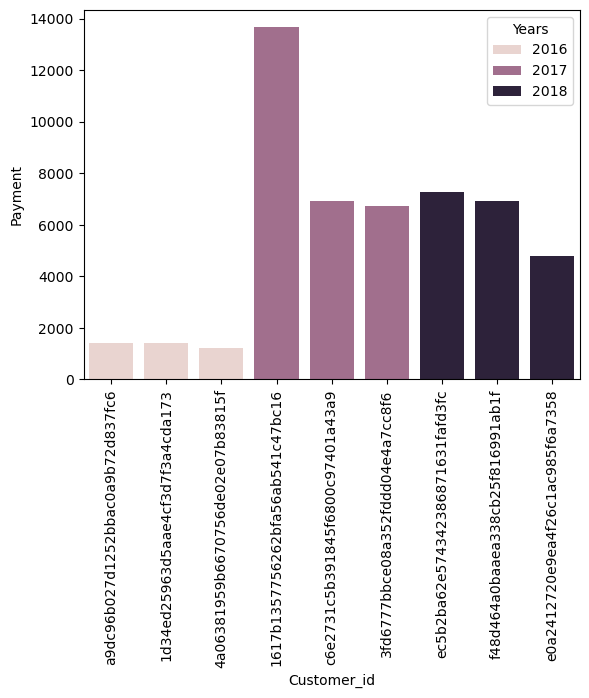

In [66]:
# Safely discard unread results from any previous query
while cur.nextset():
    pass

# Now run your actual query
query = """
WITH A AS(SELECT orders.customer_id, ROUND(SUM(payments.payment_value),2) AS Payment, YEAR(orders.order_purchase_timestamp) AS years, 
DENSE_RANK() OVER(PARTITION BY YEAR(orders.order_purchase_timestamp) ORDER BY (SUM(payments.payment_value)) DESC ) AS d_rank FROM orders
JOIN payments
ON orders.order_id = payments.order_id
GROUP BY orders.customer_id, orders.order_purchase_timestamp)
SELECT years,customer_id, payment FROM A
WHERE d_rank < 4;
"""
cur.execute(query)
data = cur.fetchall()


df = pd.DataFrame(data, columns = ['Years','Customer_id','Payment'])
sns.barplot(x = 'Customer_id', y = 'Payment', data = df, hue = 'Years')
plt.xticks(rotation = 90)
plt.show()
